# LLM-based Feature Engineering for Multimodal Tabular Data

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
from auto_mm_bench.datasets import dataset_registry, _TEXT

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

## Exploring Benchmark Datasets

In [2]:
available_datasets = dataset_registry.list_keys()
print(f"Total datasets: {len(available_datasets)}")

for i, dataset_key in enumerate(available_datasets, 1):
    print(f"{i:2d}. {dataset_key}")

sample_dataset = 'product_sentiment_machine_hack'

train_dataset = dataset_registry.create(sample_dataset, 'train')
test_dataset = dataset_registry.create(sample_dataset, 'test')

print(f"\nProblem type: {train_dataset.problem_type}")
print(f"Evaluation metric: {train_dataset.metric}")
print(f"Feature columns: {train_dataset.feature_columns}")
print(f"Label columns: {train_dataset.label_columns}")
print(f"Training samples: {len(train_dataset.data)}")
print(f"Test samples: {len(test_dataset.data)}")

feature_types = train_dataset.feature_types
text_columns = [col for col, ftype in zip(train_dataset.feature_columns, feature_types) if ftype == _TEXT]
print(f"\nText columns: {text_columns}")

train_data = train_dataset.data
print(f"\nSample data:")
print(train_data.head())

print(f"\nTarget distribution:")
print(train_data[train_dataset.label_columns[0]].value_counts())

Total datasets: 27
 1. product_sentiment_machine_hack
 2. jigsaw_unintended_bias
 3. jigsaw_unintended_bias100K
 4. google_qa_label
 5. google_qa_answer_helpful
 6. google_qa_answer_plausible
 7. google_qa_answer_type_procedure
 8. google_qa_answer_type_reason_explanation
 9. google_qa_question_type_reason_explanation
10. google_qa_answer_satisfaction
11. women_clothing_review
12. melbourne_airbnb
13. mercari_price_suggestion
14. ae_price_prediction
15. mercari_price_suggestion100K
16. imdb_genre_prediction
17. fake_job_postings
18. kick_starter_funding
19. jc_penney_products
20. wine_reviews
21. news_popularity
22. news_channel
23. news_popularity2
24. fake_job_postings2
25. bookprice_prediction
26. data_scientist_salary
27. california_house_price

Problem type: multiclass
Evaluation metric: acc
Feature columns: ['Product_Description', 'Product_Type']
Label columns: ['Sentiment']
Training samples: 5091
Test samples: 1273

Text columns: ['Product_Description']

Sample data:
   Unnamed:

## Feature Engineering Classes

In [ ]:
class TFIDFFeatureEngineer:
    """
    TF-IDF based feature engineering for text columns.
    
    Attributes:
        max_features (int): Maximum number of features to extract per text column
        min_df (int): Minimum document frequency for terms to be included
        ngram_range (tuple): Range of n-grams to extract (min_n, max_n)
        vectorizers (dict): Dictionary storing fitted TfidfVectorizer objects for each column
    """
    
    def __init__(self, max_features=1000, min_df=2, ngram_range=(1, 2)):
        """
        Initialize the TF-IDF feature engineer.
        
        Args:
            max_features (int, optional): Maximum number of features to extract. Defaults to 1000.
            min_df (int, optional): Minimum document frequency. Defaults to 2.
            ngram_range (tuple, optional): N-gram range (min_n, max_n). Defaults to (1, 2).
        """
        self.max_features = max_features
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.vectorizers = {}
        
    def fit(self, data, text_columns):
        """
        Fit TF-IDF vectorizers on training data.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            TFIDFFeatureEngineer: Self for method chaining
        """
        print(f"Fitting TF-IDF vectorizers for columns: {text_columns}")
        
        for col in text_columns:
            print(f"Processing {col}...")
            
            vectorizer = TfidfVectorizer(
                max_features=self.max_features,
                min_df=self.min_df,
                ngram_range=self.ngram_range,
                stop_words='english'
            )
            
            texts = data[col].astype(str).fillna('')
            vectorizer.fit(texts)
            self.vectorizers[col] = vectorizer
            
            print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        
        return self
    
    def transform(self, data, text_columns):
        """
        Transform data using fitted vectorizers.
        
        Args:
            data (pd.DataFrame): Data to transform containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional TF-IDF feature columns
        """
        result_data = data.copy()
        
        for col in text_columns:
            if col in self.vectorizers:
                print(f"Transforming {col}...")
                
                texts = data[col].astype(str).fillna('')
                features = self.vectorizers[col].transform(texts)
                
                feature_names = [f"{col}_tfidf_{i}" for i in range(features.shape[1])]
                text_df = pd.DataFrame(features.toarray(), columns=feature_names, index=data.index)
                result_data = pd.concat([result_data, text_df], axis=1)
                
                print(f"Generated {features.shape[1]} features")
        
        return result_data
    
    def fit_transform(self, data, text_columns):
        """
        Fit and transform in one step.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional TF-IDF feature columns
        """
        return self.fit(data, text_columns).transform(data, text_columns)

In [ ]:
class CountVectorizerFeatureEngineer:
    """
    Count Vectorizer based feature engineering for text columns.
    
    Attributes:
        max_features (int): Maximum number of features to extract per text column
        min_df (int): Minimum document frequency for terms to be included
        ngram_range (tuple): Range of n-grams to extract (min_n, max_n)
        vectorizers (dict): Dictionary storing fitted CountVectorizer objects for each column
    """
    
    def __init__(self, max_features=1000, min_df=2, ngram_range=(1, 2)):
        """
        Initialize the enhanced Count Vectorizer feature engineer.
        
        Args:
            max_features (int, optional): Maximum number of features to extract. Defaults to 1000.
            min_df (int, optional): Minimum document frequency. Defaults to 2.
            ngram_range (tuple, optional): N-gram range (min_n, max_n). Defaults to (1, 2).
        """
        self.max_features = max_features
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.vectorizers = {}
        
    def fit(self, data, text_columns):
        """
        Fit Count vectorizers on training data.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            CountVectorizerFeatureEngineer: Self for method chaining
        """
        print(f"Fitting enhanced Count vectorizers for columns: {text_columns}")
        
        for col in text_columns:
            print(f"Processing {col}...")
            
            vectorizer = CountVectorizer(
                max_features=self.max_features,
                min_df=self.min_df,
                ngram_range=self.ngram_range,
                stop_words='english',
                lowercase=True,
                strip_accents='ascii',
                token_pattern=r'\b[a-zA-Z]{2,}\b'
            )
            
            texts = data[col].astype(str).fillna('')
            vectorizer.fit(texts)
            self.vectorizers[col] = vectorizer
            
            print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        
        return self
    
    def transform(self, data, text_columns):
        """
        Transform data using fitted vectorizers.
        
        Args:
            data (pd.DataFrame): Data to transform containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional count vectorizer feature columns
        """
        result_data = data.copy()
        
        for col in text_columns:
            if col in self.vectorizers:
                print(f"Transforming {col}...")
                
                texts = data[col].astype(str).fillna('')
                features = self.vectorizers[col].transform(texts)
                
                feature_names = [f"{col}_count_{i}" for i in range(features.shape[1])]
                text_df = pd.DataFrame(features.toarray(), columns=feature_names, index=data.index)
                result_data = pd.concat([result_data, text_df], axis=1)
                
                print(f"Generated {features.shape[1]} count features")
        
        return result_data
    
    def fit_transform(self, data, text_columns):
        """
        Fit and transform in one step.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional count vectorizer feature columns
        """
        return self.fit(data, text_columns).transform(data, text_columns)

In [ ]:
class LLMFeatureEngineer:
    """
    LLM-based feature engineering using DistilBERT embeddings.
    
    Attributes:
        model_name (str): Hugging Face model identifier for the transformer model
        n_components (int): Number of PCA components for dimensionality reduction
        max_length (int): Maximum sequence length for tokenization
        pca_transformers (dict): Dictionary storing fitted PCA objects for each text column
        use_real_llm (bool): Flag indicating whether DistilBERT model loaded successfully
        tokenizer (AutoTokenizer): Hugging Face tokenizer for text preprocessing
        model (AutoModel): Hugging Face transformer model for generating embeddings
    """
    
    def __init__(self, model_name='distilbert-base-uncased', n_components=50, max_length=128):
        """
        Initialize the LLM feature engineer.
        
        Args:
            model_name (str): Hugging Face model identifier
            n_components (int): Number of PCA components for dimensionality reduction
            max_length (int): Maximum sequence length for tokenization
        """
        self.model_name = model_name
        self.n_components = n_components
        self.max_length = max_length
        self.pca_transformers = {}
        self.use_real_llm = False
        
        self._initialize_model()
    
    def _initialize_model(self):
        """Initialize the DistilBERT model and tokenizer."""
        print(f"Initializing LLM Feature Engineer with {self.model_name}")
        
        try:
            from transformers import AutoTokenizer, AutoModel
            import torch
            
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name)
            
            self.model.eval()
            torch.set_grad_enabled(False)
            
            print(f"Embedding dimension: {self.model.config.hidden_size}")
            self.use_real_llm = True
            
        except Exception as e:
            print(f"Failed to load DistilBERT model: {e}")
            print("Falling back to TF-IDF + SVD approach")
            self.use_real_llm = False
    
    def _generate_embeddings(self, texts):
        """
        Generate embeddings using DistilBERT or fallback method.
        
        Args:
            texts (list): List of text strings to embed
            
        Returns:
            np.ndarray: Generated embeddings matrix
        """
        if not self.use_real_llm:
            return self._generate_fallback_embeddings(texts)
        
        try:
            import torch
            
            print(f"Generating DistilBERT embeddings for {len(texts)} texts...")
            
            batch_size = 8
            embeddings = []
            
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                inputs = self.tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=self.max_length,
                    return_tensors='pt'
                )
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                    embeddings.append(batch_embeddings)
                
            
            final_embeddings = np.vstack(embeddings)
            print(f"Generated embeddings shape: {final_embeddings.shape}")
            return final_embeddings
            
        except Exception as e:
            print(f"Error generating DistilBERT embeddings: {e}")
            print("Falling back to TF-IDF + SVD")
            self.use_real_llm = False
            return self._generate_fallback_embeddings(texts)
    
    def _generate_fallback_embeddings(self, texts):
        """
        Generate embeddings using TF-IDF + SVD fallback method.
        
        Args:
            texts (list): List of text strings to embed
            
        Returns:
            np.ndarray: Generated embeddings matrix
        """
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import TruncatedSVD
        
        print("Using TF-IDF + SVD fallback for embeddings")
        
        vectorizer = TfidfVectorizer(
            max_features=1000, 
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2
        )
        tfidf_features = vectorizer.fit_transform(texts)
        
        if tfidf_features.shape[1] >= self.n_components:
            svd = TruncatedSVD(n_components=self.n_components, random_state=42)
            embeddings = svd.fit_transform(tfidf_features)
        else:
            embeddings = tfidf_features.toarray()
        
        return embeddings
    
    def fit(self, data, text_columns):
        """
        Fit PCA transformers on training embeddings.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            LLMFeatureEngineer: Self for method chaining
        """
        print(f"Fitting LLM feature engineer on columns: {text_columns}")
        
        for col in text_columns:
            print(f"Processing column: {col}")
            
            texts = data[col].astype(str).fillna('').tolist()
            texts = [text[:500] for text in texts]
            
            embeddings = self._generate_embeddings(texts)
            
            if (self.use_real_llm and 
                embeddings.shape[1] > self.n_components and 
                embeddings.shape[0] > self.n_components):
                
                from sklearn.decomposition import PCA
                
                pca = PCA(n_components=self.n_components, random_state=42)
                pca.fit(embeddings)
                self.pca_transformers[col] = pca
                
                print(f"Fitted PCA: {embeddings.shape[1]} → {pca.n_components_} dimensions")
                print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
            else:
                self.pca_transformers[col] = None
                print(f"Using embeddings directly: {embeddings.shape[1]} dimensions")
        
        return self
    
    def transform(self, data, text_columns):
        """
        Transform data using fitted models.
        
        Args:
            data (pd.DataFrame): Data to transform containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional LLM feature columns
        """
        result_data = data.copy()
        
        for col in text_columns:
            if col in self.pca_transformers:
                print(f"Transforming {col}...")
                
                texts = data[col].astype(str).fillna('').tolist()
                texts = [text[:500] for text in texts]
                
                embeddings = self._generate_embeddings(texts)
                
                if self.pca_transformers[col] is not None:
                    final_embeddings = self.pca_transformers[col].transform(embeddings)
                else:
                    final_embeddings = embeddings
                
                embedding_type = "distilbert" if self.use_real_llm else "tfidf_svd"
                feature_names = [f"{col}_{embedding_type}_{i}" for i in range(final_embeddings.shape[1])]
                
                text_df = pd.DataFrame(final_embeddings, columns=feature_names, index=data.index)
                result_data = pd.concat([result_data, text_df], axis=1)
                
                print(f"Generated {final_embeddings.shape[1]} {embedding_type} features")
        
        return result_data
    
    def fit_transform(self, data, text_columns):
        """
        Fit and transform in one step.
        
        Args:
            data (pd.DataFrame): Training data containing text columns
            text_columns (list): List of column names containing text data
            
        Returns:
            pd.DataFrame: Original data with additional LLM feature columns
        """
        return self.fit(data, text_columns).transform(data, text_columns)

## 4. Comprehensive Benchmark Comparison

Now let's compare all three feature engineering approaches on our selected dataset.

In [6]:
def run_single_dataset_benchmark(dataset_name, sample_size=None):
    """
    Run benchmark on a single dataset comparing different feature engineering approaches.
    
    This function loads a dataset, applies three different feature engineering strategies
    (count vectorizer, TF-IDF, and LLM embeddings), trains models, and evaluates performance.
    
    Args:
        dataset_name (str): Name of the dataset from the benchmark registry
        sample_size (int, optional): Maximum number of training samples to use. 
                                    If None, uses full dataset. Defaults to None.
        
    Returns:
        list: List of dictionaries containing benchmark results for each strategy
        
    Notes:
        - Only processes datasets that contain text columns
        - Uses reduced feature counts for faster processing
        - Handles both classification and regression problems
        - Returns empty list if dataset loading fails
    """
    print(f"Dataset: {dataset_name}")
    
    try:
        train_dataset = dataset_registry.create(dataset_name, 'train')
        test_dataset = dataset_registry.create(dataset_name, 'test')
        
        train_data = train_dataset.data
        test_data = test_dataset.data
        
        if sample_size is None:
            train_sample = train_data
            test_sample = test_data
        else:
            train_sample = train_data.sample(n=min(sample_size, len(train_data)), random_state=42)
            test_sample = test_data.sample(n=min(sample_size//2, len(test_data)), random_state=42)
        
        feature_types = train_dataset.feature_types
        text_columns = [col for col, ftype in zip(train_dataset.feature_columns, feature_types) if ftype == _TEXT]
        
        if not text_columns:
            print(f"No text columns found in {dataset_name}")
            return []

        print(f"Text columns: {text_columns}")
        print(f"Training samples: {len(train_sample)}")
        print(f"Test samples: {len(test_sample)}")
        
        results = []
        
        # Strategy 1: Enhanced Count Vectorizer
        print(f"count_vectorizer...", end=" ")
        try:
            start_time = time.time()
            
            fe = CountVectorizerFeatureEngineer(max_features=500)
            train_features = fe.fit_transform(train_sample, text_columns)
            test_features = fe.transform(test_sample, text_columns)
            
            X_train = train_features.select_dtypes(include=[np.number]).fillna(0)
            X_test = test_features.select_dtypes(include=[np.number]).fillna(0)
            y_train = train_sample[train_dataset.label_columns[0]].values
            y_test = test_sample[train_dataset.label_columns[0]].values
            
            if X_train.shape[1] != X_test.shape[1]:
                common_cols = set(X_train.columns) & set(X_test.columns)
                X_train = X_train[list(common_cols)]
                X_test = X_test[list(common_cols)]
            
            if train_dataset.problem_type == 'multiclass':
                model = LogisticRegression(random_state=42, max_iter=1000)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                metric_name = 'Accuracy'
            else:
                from sklearn.ensemble import RandomForestRegressor
                model = RandomForestRegressor(random_state=42, n_estimators=20)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = r2_score(y_test, y_pred)
                metric_name = 'R²'
            
            processing_time = time.time() - start_time
            
            results.append({
                'dataset': dataset_name,
                'strategy': 'count_vectorizer',
                'score': score,
                'metric': metric_name,
                'n_features': X_train.shape[1],
                'processing_time': processing_time,
                'problem_type': train_dataset.problem_type
            })
            
            print(f"{score:.3f} ({processing_time:.1f}s)")
            
        except Exception as e:
            print(f"Error: {str(e)[:50]}...")
        
        # Strategy 2: TF-IDF
        print(f"tfidf...", end=" ")
        try:
            start_time = time.time()
            
            fe = TFIDFFeatureEngineer(max_features=200)
            train_features = fe.fit_transform(train_sample, text_columns)
            test_features = fe.transform(test_sample, text_columns)
            
            X_train = train_features.select_dtypes(include=[np.number]).fillna(0)
            X_test = test_features.select_dtypes(include=[np.number]).fillna(0)
            y_train = train_sample[train_dataset.label_columns[0]].values
            y_test = test_sample[train_dataset.label_columns[0]].values
            
            if X_train.shape[1] != X_test.shape[1]:
                common_cols = set(X_train.columns) & set(X_test.columns)
                X_train = X_train[list(common_cols)]
                X_test = X_test[list(common_cols)]
            
            if train_dataset.problem_type == 'multiclass':
                model = LogisticRegression(random_state=42, max_iter=1000)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                metric_name = 'Accuracy'
            else:
                from sklearn.ensemble import RandomForestRegressor
                model = RandomForestRegressor(random_state=42, n_estimators=20)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = r2_score(y_test, y_pred)
                metric_name = 'R²'
            
            processing_time = time.time() - start_time
            
            results.append({
                'dataset': dataset_name,
                'strategy': 'tfidf',
                'score': score,
                'metric': metric_name,
                'n_features': X_train.shape[1],
                'processing_time': processing_time,
                'problem_type': train_dataset.problem_type
            })
            
            print(f"{score:.3f} ({processing_time:.1f}s)")
            
        except Exception as e:
            print(f"Error: {str(e)[:50]}...")
        
        # Strategy 3: LLM Embeddings
        print(f"llm_embeddings...", end=" ")
        try:
            start_time = time.time()
            
            fe = LLMFeatureEngineer(n_components=30)
            train_features = fe.fit_transform(train_sample, text_columns)
            test_features = fe.transform(test_sample, text_columns)
            
            X_train = train_features.select_dtypes(include=[np.number]).fillna(0)
            X_test = test_features.select_dtypes(include=[np.number]).fillna(0)
            y_train = train_sample[train_dataset.label_columns[0]].values
            y_test = test_sample[train_dataset.label_columns[0]].values
            
            if X_train.shape[1] != X_test.shape[1]:
                common_cols = set(X_train.columns) & set(X_test.columns)
                X_train = X_train[list(common_cols)]
                X_test = X_test[list(common_cols)]
            
            if train_dataset.problem_type == 'multiclass':
                model = LogisticRegression(random_state=42, max_iter=1000)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                metric_name = 'Accuracy'
            else:
                from sklearn.ensemble import RandomForestRegressor
                model = RandomForestRegressor(random_state=42, n_estimators=20)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = r2_score(y_test, y_pred)
                metric_name = 'R²'
            
            processing_time = time.time() - start_time
            
            results.append({
                'dataset': dataset_name,
                'strategy': 'llm_embeddings',
                'score': score,
                'metric': metric_name,
                'n_features': X_train.shape[1],
                'processing_time': processing_time,
                'problem_type': train_dataset.problem_type
            })
            
            print(f"{score:.3f} ({processing_time:.1f}s)")
            
        except Exception as e:
            print(f"LLM Error: {str(e)[:50]}...")
        
        return results
        
    except Exception as e:
        print(f"Failed to load dataset: {str(e)}")
        return []

def run_multi_dataset_benchmark(sample_size=None):
    """
    Run comprehensive benchmark across multiple datasets from different domains.
    
    Args:
        sample_size (int, optional): Maximum number of training samples per dataset. 
                                   If None, uses full dataset size. Defaults to None.
        
    Returns:
        pd.DataFrame: DataFrame containing all benchmark results with columns:
            - dataset: Dataset name
            - strategy: Feature engineering strategy used
            - score: Performance score (accuracy or R²)
            - metric: Type of metric used
            - n_features: Number of features generated
            - processing_time: Time taken for feature engineering and training
            - problem_type: Classification or regression
    """
    
    test_datasets = [
        'product_sentiment_machine_hack',
        'women_clothing_review'
    ]

    print(f"Testing {len(test_datasets)} datasets")
    if sample_size:
        print(f"Sample size per dataset: {sample_size}")
    else:
        print("Using full dataset sizes")
    print()
    
    all_results = []
    
    for i, dataset_name in enumerate(test_datasets, 1):
        print(f"[{i}/{len(test_datasets)}] {dataset_name}")
        dataset_results = run_single_dataset_benchmark(dataset_name, sample_size)
        all_results.extend(dataset_results)
        print()
    
    return pd.DataFrame(all_results)


results_df = run_multi_dataset_benchmark(sample_size=None)

if not results_df.empty:
    
    summary = results_df.groupby('strategy').agg({
        'score': ['mean', 'std', 'count'],
        'processing_time': 'mean',
        'n_features': 'mean'
    }).round(3)
    
    print("Performance Summary by Strategy:")
    print(summary.to_string())
    print()
    
    print("Detailed Results by Dataset:")
    detailed = results_df.pivot_table(index='dataset', columns='strategy', values='score', fill_value=0).round(3)
    print(detailed.to_string())
    
else:
    print("No successful experiments completed")

Testing 2 datasets
Using full dataset sizes

[1/2] product_sentiment_machine_hack
Dataset: product_sentiment_machine_hack
Text columns: ['Product_Description']
Training samples: 5091
Test samples: 1273
count_vectorizer... Fitting enhanced Count vectorizers for columns: ['Product_Description']
Processing Product_Description...
Text columns: ['Product_Description']
Training samples: 5091
Test samples: 1273
count_vectorizer... Fitting enhanced Count vectorizers for columns: ['Product_Description']
Processing Product_Description...
Vocabulary size: 500
Transforming Product_Description...
Vocabulary size: 500
Transforming Product_Description...
Generated 500 count features
Transforming Product_Description...
Generated 500 count features
Generated 500 count features
Transforming Product_Description...
Generated 500 count features
0.964 (120.9s)
tfidf... Fitting TF-IDF vectorizers for columns: ['Product_Description']
Processing Product_Description...
Vocabulary size: 200
Transforming Product_

## 5. Results Visualization and Analysis

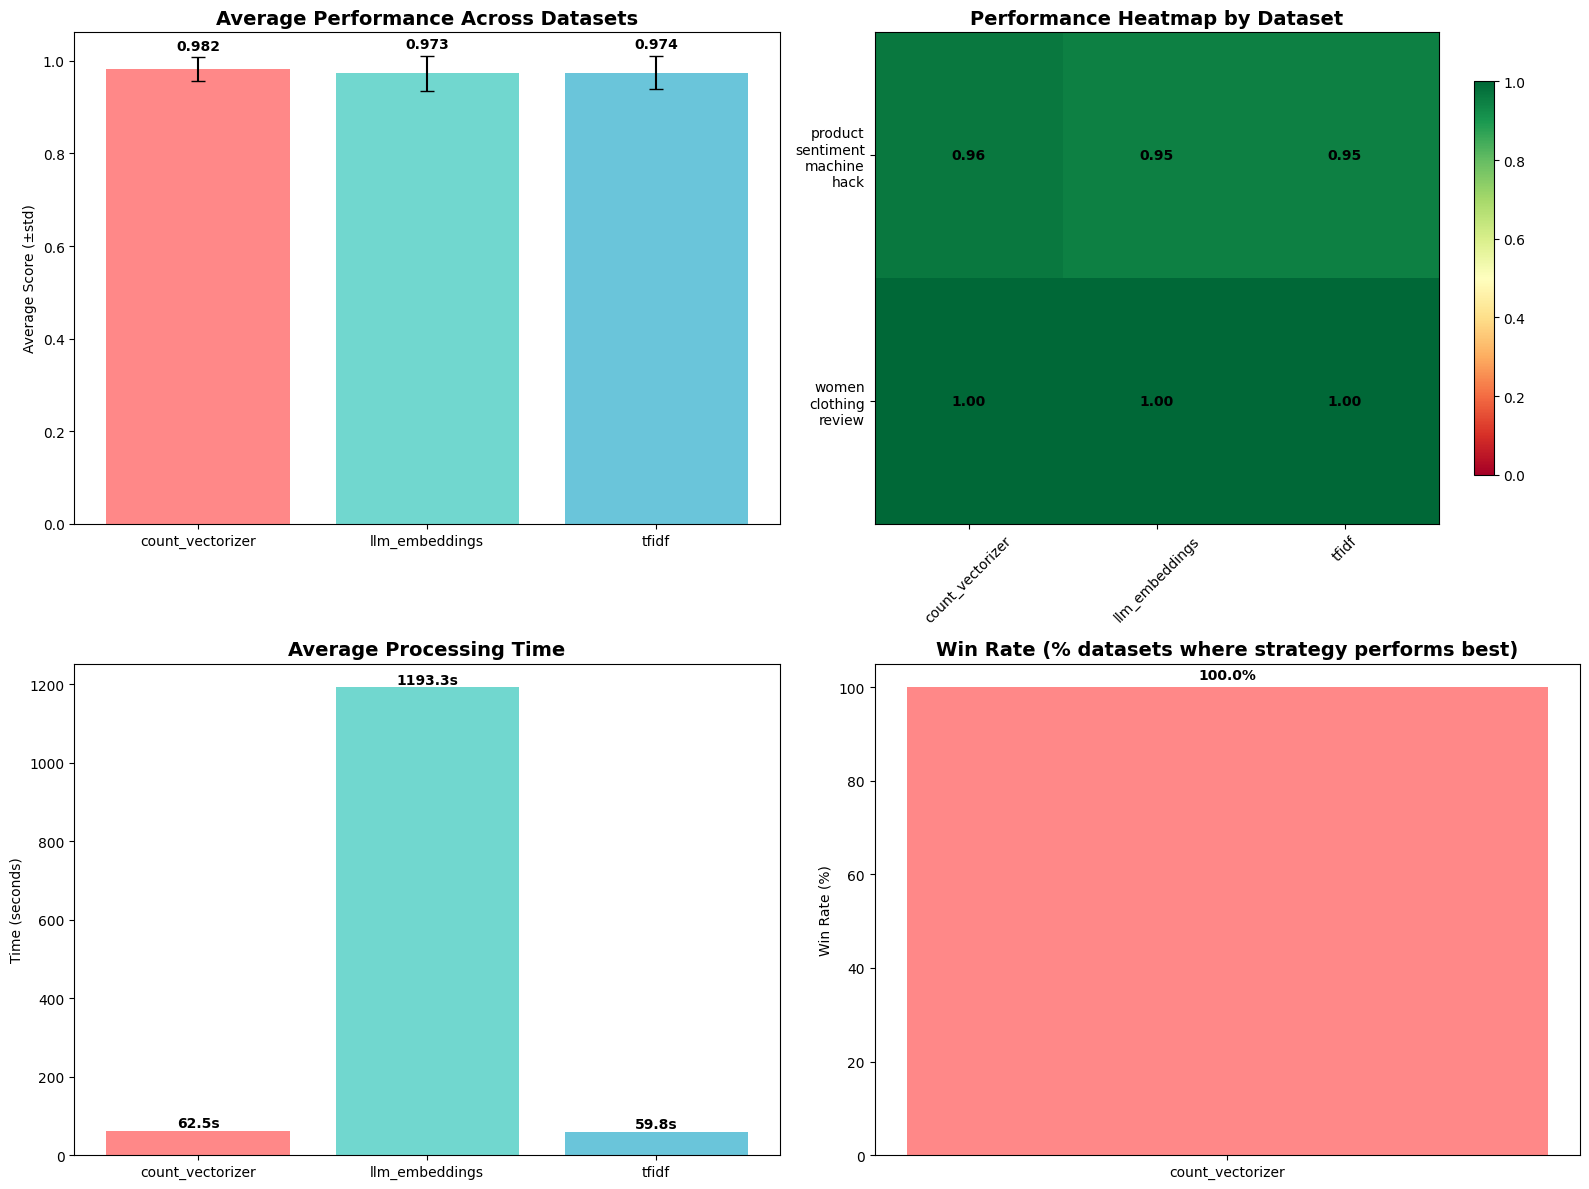

Overall Performance Statistics:
                  score                    processing_time n_features
                   mean    std    min  max            mean       mean
strategy                                                             
count_vectorizer  0.982  0.026  0.964  1.0          62.454      755.0
llm_embeddings    0.973  0.038  0.947  1.0        1193.331       50.0
tfidf             0.974  0.036  0.949  1.0          59.834      305.0

Best Average Performance: count_vectorizer
Most Consistent: count_vectorizer
Fastest on Average: tfidf

Dataset-Specific Insights:
   • product_sentiment_machine_hack: count_vectorizer (0.964)
   • women_clothing_review: count_vectorizer (1.000)


In [7]:
if not results_df.empty:
    """
    Comprehensive visualization and analysis of benchmark results.
    
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Average performance by strategy
    avg_performance = results_df.groupby('strategy')['score'].agg(['mean', 'std']).reset_index()
    bars1 = ax1.bar(avg_performance['strategy'], avg_performance['mean'], 
                    yerr=avg_performance['std'], capsize=5,
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    ax1.set_title('Average Performance Across Datasets', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Score (±std)')
    for bar, mean_val, std_val in zip(bars1, avg_performance['mean'], avg_performance['std']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.01,
                 f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Performance by dataset (heatmap)
    pivot_data = results_df.pivot_table(index='dataset', columns='strategy', values='score', fill_value=0)
    im = ax2.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax2.set_title('Performance Heatmap by Dataset', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(pivot_data.columns)))
    ax2.set_yticks(range(len(pivot_data.index)))
    ax2.set_xticklabels(pivot_data.columns, rotation=45)
    ax2.set_yticklabels([name.replace('_', '\n') for name in pivot_data.index], fontsize=10)
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            value = pivot_data.iloc[i, j]
            if value > 0:
                text_color = 'white' if value < 0.5 else 'black'
                ax2.text(j, i, f'{value:.2f}', ha='center', va='center', 
                        color=text_color, fontweight='bold')
    
    plt.colorbar(im, ax=ax2, shrink=0.8)
    
    # 3. Processing time comparison
    avg_time = results_df.groupby('strategy')['processing_time'].mean()
    bars3 = ax3.bar(avg_time.index, avg_time.values,
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    ax3.set_title('Average Processing Time', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Time (seconds)')
    for bar, time_val in zip(bars3, avg_time.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 4. Win rate analysis
    # Count how often each strategy performs best per dataset
    win_counts = results_df.loc[results_df.groupby('dataset')['score'].idxmax()]['strategy'].value_counts()
    total_datasets = results_df['dataset'].nunique()
    win_rates = (win_counts / total_datasets * 100).fillna(0)
    
    bars4 = ax4.bar(win_rates.index, win_rates.values,
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(win_rates)], alpha=0.8)
    ax4.set_title('Win Rate (% datasets where strategy performs best)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Win Rate (%)')
    for bar, rate in zip(bars4, win_rates.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    overall_stats = results_df.groupby('strategy').agg({
        'score': ['mean', 'std', 'min', 'max'],
        'processing_time': 'mean',
        'n_features': 'mean'
    }).round(3)
    
    print("Overall Performance Statistics:")
    print(overall_stats.to_string())
    print()
    
    best_avg = results_df.groupby('strategy')['score'].mean().idxmax()
    most_consistent = results_df.groupby('strategy')['score'].std().idxmin()
    fastest_avg = results_df.groupby('strategy')['processing_time'].mean().idxmin()
    
    print(f"Best Average Performance: {best_avg}")
    print(f"Most Consistent: {most_consistent}")
    print(f"Fastest on Average: {fastest_avg}")
    
    print(f"\nDataset-Specific Insights:")
    for dataset in results_df['dataset'].unique():
        dataset_results = results_df[results_df['dataset'] == dataset]
        best_for_dataset = dataset_results.loc[dataset_results['score'].idxmax()]
        print(f"   • {dataset}: {best_for_dataset['strategy']} ({best_for_dataset['score']:.3f})")
    
else:
    print("No results to visualize")